# Introduction

Stroke is a serious medical condition that can lead to long-term disability or death. Early prediction of stroke risk can help improve patient outcomes through timely intervention.

In this project, we explore machine learning models to predict whether a patient is likely to suffer a stroke, using health-related data such as age, glucose level, BMI, and medical history. We focus on handling imbalanced data and improving recall, as missing a true stroke case can be critical in healthcare.

Here we decided to use two models **Random Forest and Logistic Regression**, which will be evaluated and compared based on key metrics like **recall, F1-score, and ROC-AUC.**

# 1.Set up and Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, roc_auc_score, recall_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 2.Data Overview

## 2.1 Read The Data

In [19]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

## 2.2.Veiw Sample of Data

In [20]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2.3.Data Overveiw

In [21]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000




We loaded the Stroke Prediction Dataset, which contains **5110 patient records** and **12 columns**. Each row represents an individual patient, and the dataset includes a mix of numerical and categorical features. Here are the finding we got from the dataset,

- The target variable is `stroke`, which is binary (0 = No stroke, 1 = Stroke).
- Most features have complete data, but the `bmi` column contains some missing values that we will need to address during preprocessing.
- The dataset includes both demographic attributes (e.g., `gender`, `age`, `ever_married`) and health indicators (e.g., `hypertension`, `heart_disease`, `avg_glucose_level`).
- Numerical columns like `age`, `avg_glucose_level`, and `bmi` show variation in range and distribution, which may influence model performance and will require scaling or normalization.

Next, we will clean the data and handle missing values to prepare it for analysis.


## 2.4.Data Cleaning

In [22]:
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

null_valus = df.isnull().sum()
print(f"Number of Null valus in each column: {null_valus}")

duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of Null valus in each column: id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Number of duplicate rows: 0


In [23]:
print("Unique gender values before:", df['gender'].unique())

df = df[df['gender'] != 'Other']

print("Unique gender values after:", df['gender'].unique())

Unique gender values before: ['Male' 'Female' 'Other']
Unique gender values after: ['Male' 'Female']


## 2.5.Feature Selection

In [24]:
selected_features = ['gender', 'age', 'hypertension', 'heart_disease',
                    'avg_glucose_level',
                     'bmi', 'smoking_status', 'stroke']
df = df[selected_features]

df.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,202.21,28.1,never smoked,1
2,Male,80.0,0,1,105.92,32.5,never smoked,1
3,Female,49.0,0,0,171.23,34.4,smokes,1
4,Female,79.0,1,0,174.12,24.0,never smoked,1


# 3.Visulization

## 3.1  Stroke Class Distribution

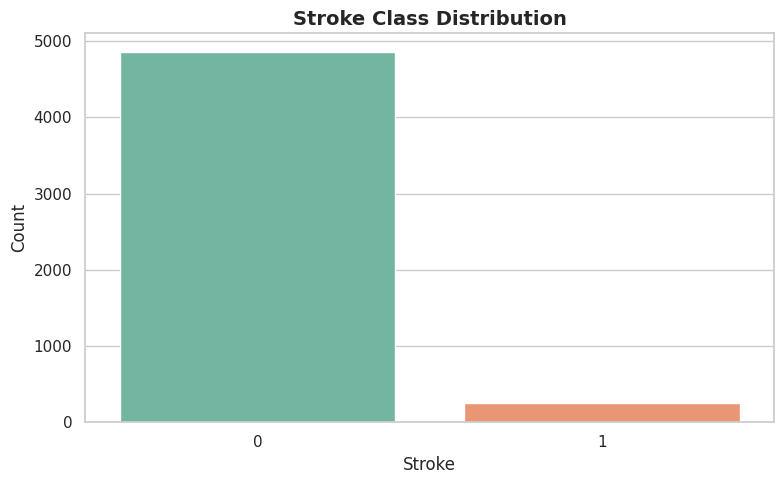

In [39]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='stroke', data=df, palette='Set2')

plt.title('Stroke Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Stroke', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

plt.show()

## 3.2.Gender Distribution

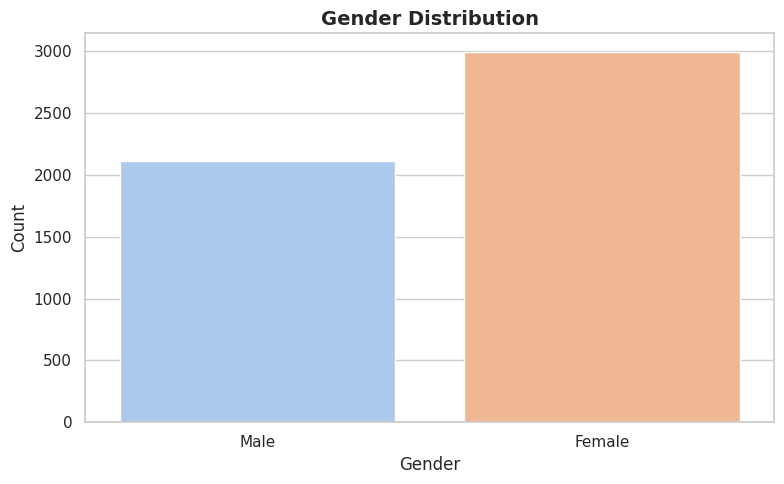

In [40]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='gender', data=df, palette='pastel')

plt.title('Gender Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


## 3.3.Smoking Status Distribution

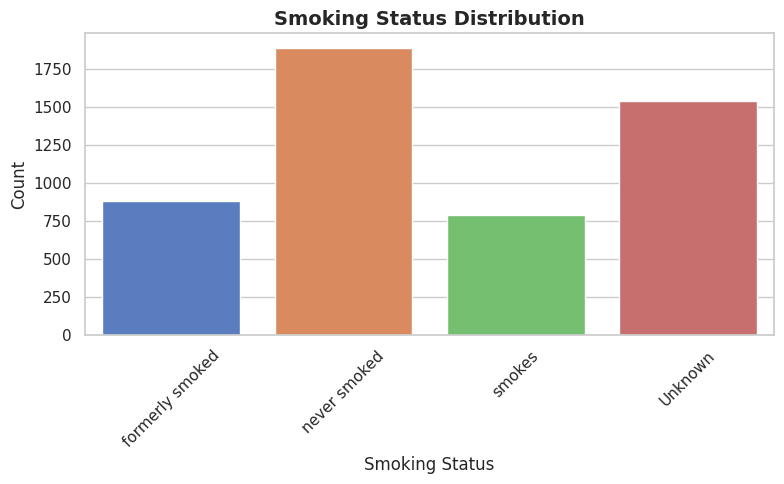

In [41]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='smoking_status', data=df, palette='muted')

plt.title('Smoking Status Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Smoking Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## 3.4.Hypertention Distribution

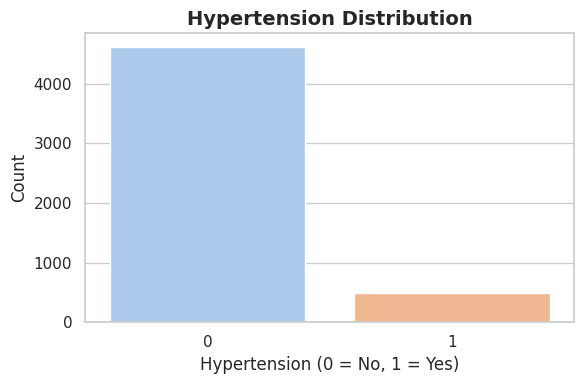

In [42]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='hypertension', data=df, palette='pastel')

plt.title('Hypertension Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Hypertension (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

plt.show()

# 4.Feature Enginerring

In [44]:
Health = df.copy()

## 4.1. Age Grouping

In [45]:
age_bins = [0, 50, 80, 120]
age_labels = ['Young adult', 'Middle-aged', 'Very old']
Health['age_group'] = pd.cut(Health['age'], bins=age_bins, labels=age_labels, right=False)

## 4.2.BMI Categories

In [46]:
bmi_bins = [0, 18.5, 25, 30, 35, 40, 100]
bmi_labels = ['Underweight', 'Healthy Weight', 'Overweight', 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity']
Health['bmi_category'] = pd.cut(Health['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

## 4.3.Interaction Feature: age × hypertension

In [47]:
Health['age_hypertension'] = Health['age'] * Health['hypertension']


## 4.4.Glucose Level Binning


In [48]:
glucose_bins = [0, 70, 85, 100, 110, 126, 140, 300]
glucose_labels = [
    'Hypoglycemia',
    'Low Normal',
    'Normal',
    'Elevated',
    'Pre-diabetic',
    'Borderline Diabetic',
    'Diabetic'
]
Health['glucose_category'] = pd.cut(Health['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels, right=False)

# Data Processing

In [27]:
# Defining categorical and numerical columns
categorical_cols = ['gender', 'smoking_status','age_group', 'bmi_category', 'glucose_category']
numerical_cols = [col for col in Health.columns if col not in categorical_cols + ['stroke']]


# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Scaling numerical data
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

# Combining both in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Model Training

In [28]:
from sklearn.model_selection import train_test_split
X = Health.drop(columns=['stroke'])
y = Health['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest


In [29]:
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("--- Random Forest ---")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

--- Random Forest ---
              precision    recall  f1-score   support

           0     0.9549    0.8812    0.9166       960
           1     0.1618    0.3548    0.2222        62

    accuracy                         0.8493      1022
   macro avg     0.5583    0.6180    0.5694      1022
weighted avg     0.9067    0.8493    0.8745      1022

ROC-AUC: 0.8067540322580645


##Logistic Regression


In [43]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [500, 1000, 2000],
}

logreg_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=cv_strategy,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

best_logreg_model = grid_search.best_estimator_
y_pred_lr = best_logreg_model.predict(X_test)
y_proba_lr = best_logreg_model.predict_proba(X_test)[:, 1]

# Threshold Tuning for Recall Boost
threshold = 0.3
y_pred_lr_thresh = (y_proba_lr >= threshold).astype(int)

print("\n--- Logistic Regression (threshold=0.3) ---")
print(classification_report(y_test, y_pred_lr_thresh, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Hyperparameters found by GridSearchCV:
{'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

--- Logistic Regression (threshold=0.3) ---
              precision    recall  f1-score   support

           0     0.9924    0.5406    0.6999       960
           1     0.1162    0.9355    0.2068        62

    accuracy                         0.5646      1022
   macro avg     0.5543    0.7381    0.4534      1022
weighted avg     0.9392    0.5646    0.6700      1022

ROC-AUC: 0.847513440860215


## Difference Between Random Forest and Logistic Regression

In [14]:
metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf)
}

metrics_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr)
}

print("--- Random Forest ---")
for metric, value in metrics_rf.items():
    print(f"{metric:10}: {value:.4f}")

print("\n--- Logistic Regression ---")
for metric, value in metrics_lr.items():
    print(f"{metric:10}: {value:.4f}")

--- Random Forest ---
Accuracy  : 0.8493
Precision : 0.1618
Recall    : 0.3548
F1-Score  : 0.2222
ROC-AUC   : 0.8068

--- Logistic Regression ---
Accuracy  : 0.7016
Precision : 0.1519
Recall    : 0.8548
F1-Score  : 0.2579
ROC-AUC   : 0.8475


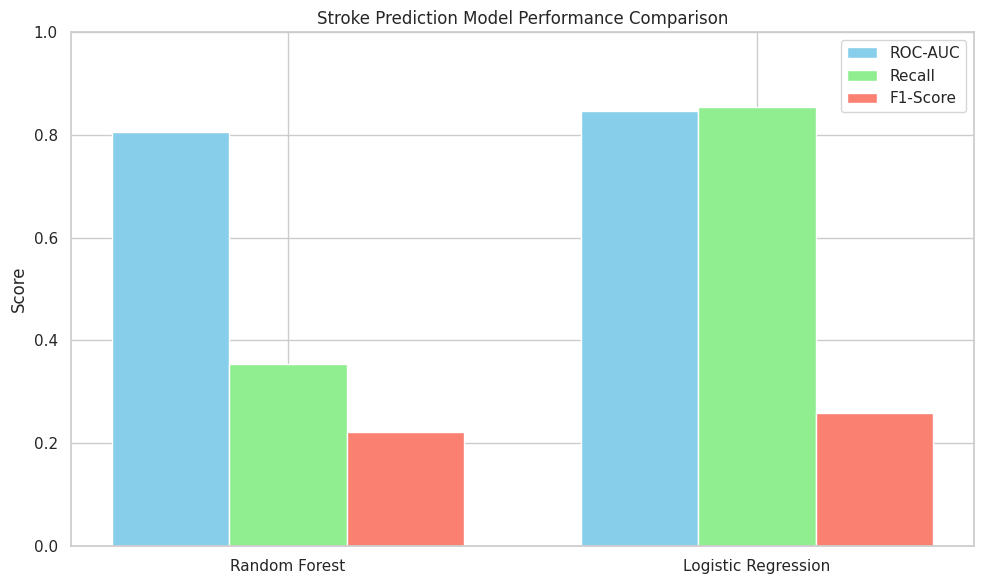

In [15]:
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

models = ['Random Forest', 'Logistic Regression']
roc_auc = [roc_auc_rf, roc_auc_lr]
recall = [recall_rf, recall_lr]
f1_scores = [f1_rf, f1_lr]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, roc_auc, width, label='ROC-AUC', color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Stroke Prediction Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

## confusion_matrix

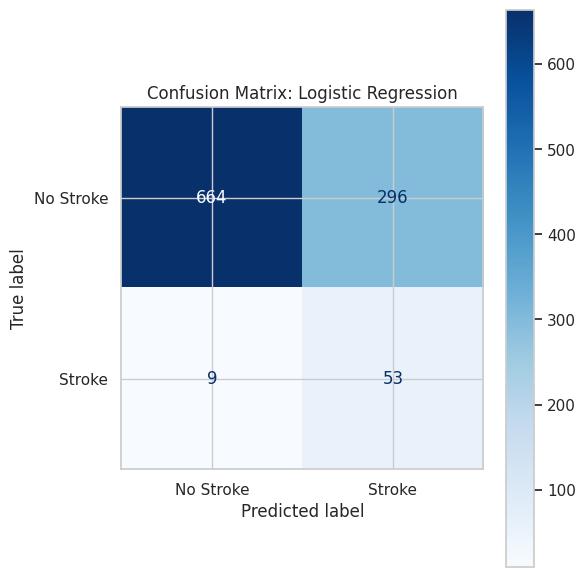

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.show()